In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import tensorflow as tf

In [2]:
#makes the random numbers predictable
np.random.seed(0)

In [3]:
#the data is pickle file (serialized)
with open ('Data/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open ('Data/valid.p', 'rb') as f:
    valid_data = pickle.load(f)
with open ('Data/test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [4]:
#train : 34799 images, dimension 32*32 , depth 3 (rgb color)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [5]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(34799,)
(4410,)
(12630,)


In [6]:
data = pd.read_csv('Data/signnames.csv')

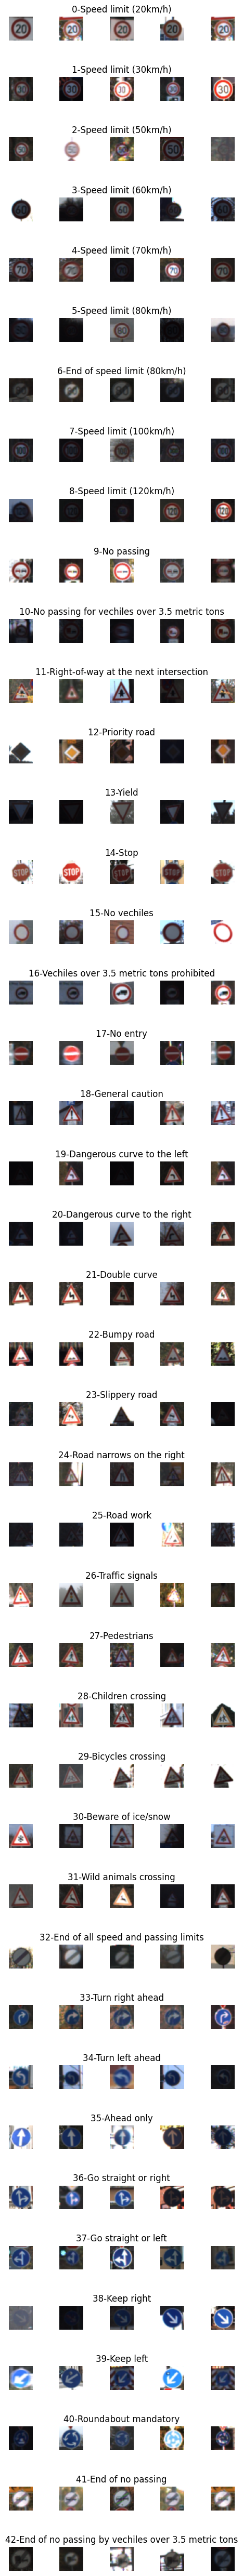

In [7]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '-' + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

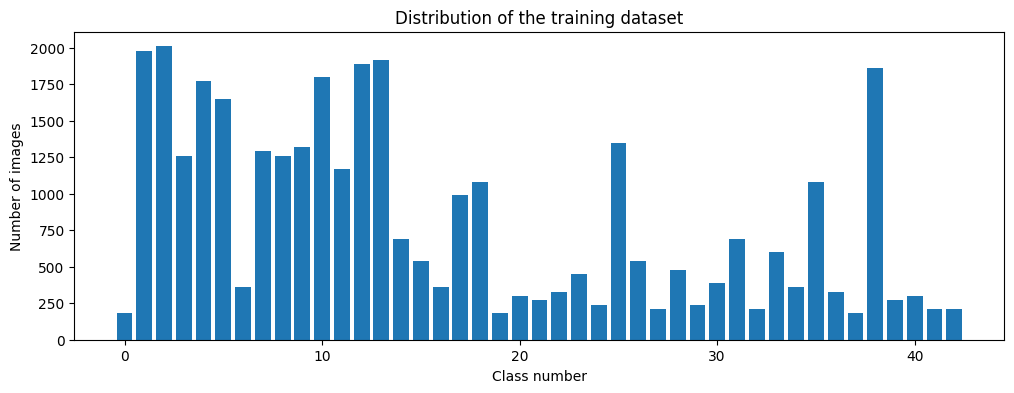

In [8]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

In [9]:
import cv2

(32, 32, 3)
36


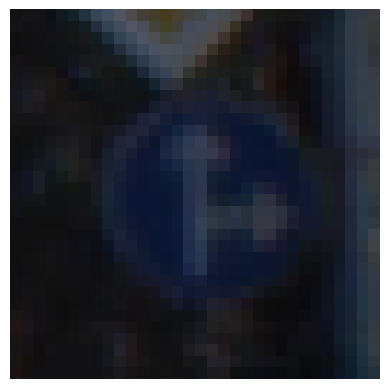

In [10]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print (y_train[1000])

In [11]:
#convert rgb image to gray image because colors are not important features ==> reduce depth ==> neural network
#with less parameters ==> neural network more efficient
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


(32, 32)


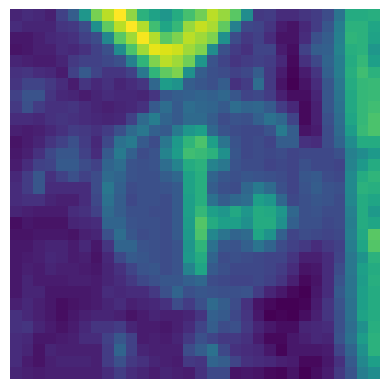

In [12]:
test = grayscale(X_train[1000])
plt.imshow(test)
plt.axis("off")
print(test.shape)

In [13]:
#histogram equalization: increase of constrat, defines better the features in the image
#equalizeHist only accept gray images (immages with depth 1)
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


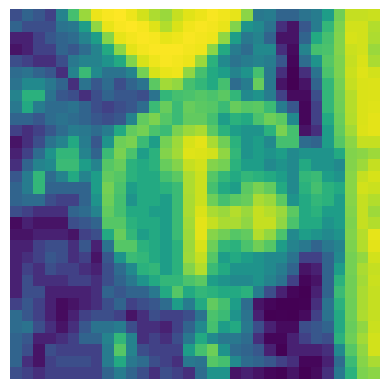

In [14]:
test = equalize(test)
plt.imshow(test)
plt.axis("off")
print(test.shape)

In [15]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    #normalization : all pixels between 0 and 1
    img = img/255
    return img

In [16]:
X_train = np.array(list(map(preprocess, X_train)))
X_val = np.array(list(map(preprocess, X_val)))
X_test = np.array(list(map(preprocess,  X_test)))

(34799, 32, 32)


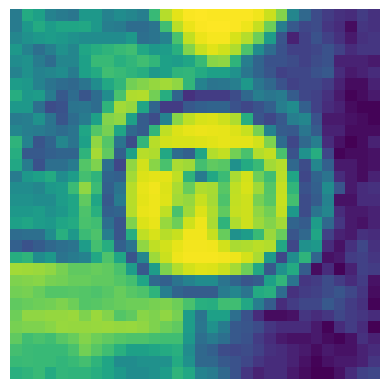

In [17]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [18]:
""" 
CNN : apply a filter to the channel of the image
(34799, 32, 32) ==> 1 channel is present
Add depth to the data
"""
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [19]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [20]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(34799,)
(4410,)
(12630,)


(34799, 32, 32, 1)


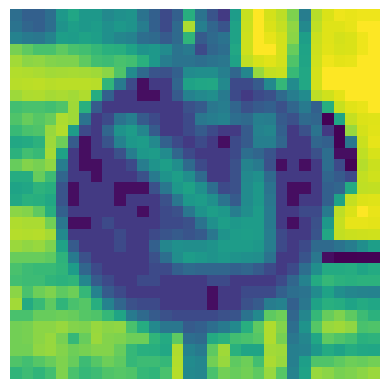

In [21]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [22]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [23]:
def leNet_model():
    model = Sequential()
    #convolutional 2D consist of filters that recognize features from the image
    #30 filters - (5, 5) size of the filter - (32, 32, 1) shape of the input image
    model.add(Conv2D(30, (5, 5) ,input_shape= (32, 32, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(15, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #reshape the output into 1D array of shape 540 = 6*6*15
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    #compile model
    model.compile(Adam(lr = 0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


In [24]:
model = leNet_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 30)        780       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 15)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 540)               0         
                                                                 
 dense (Dense)               (None, 500)               2

c:\Users\bouzi\anaconda3\envs\main\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [1]:
!nvidia-smi

Fri Nov  4 18:13:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8    N/A /  N/A |   3721MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
else:
  print("No GPU device found")

In [25]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [27]:
history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 6s 11ms/step - loss: 2.0423 - accuracy: 0.4384 - val_loss: 0.7494 - val_accuracy: 0.7689
Epoch 2/10
87/87 [==============================] - 1s 8ms/step - loss: 0.6139 - accuracy: 0.8077 - val_loss: 0.4999 - val_accuracy: 0.8494
Epoch 3/10
87/87 [==============================] - 1s 8ms/step - loss: 0.4325 - accuracy: 0.8645 - val_loss: 0.5057 - val_accuracy: 0.8444
Epoch 4/10
87/87 [==============================] - 1s 8ms/step - loss: 0.3483 - accuracy: 0.8886 - val_loss: 0.4055 - val_accuracy: 0.8853
Epoch 5/10
87/87 [==============================] - 1s 9ms/step - loss: 0.3127 - accuracy: 0.8981 - val_loss: 0.4014 - val_accuracy: 0.8898
Epoch 6/10
87/87 [==============================] - 1s 9ms/step - loss: 0.2702 - accuracy: 0.9130 - val_loss: 0.3986 - val_accuracy: 0.8930
Epoch 7/10
87/87 [==============================] - 1s 8ms/step - loss: 0.2525 - accuracy: 0.9182 - val_loss: 0.3566 - val_accuracy: 0.9025
Epoch 8/10
87/87 [=

Text(0.5, 0, 'epoch')

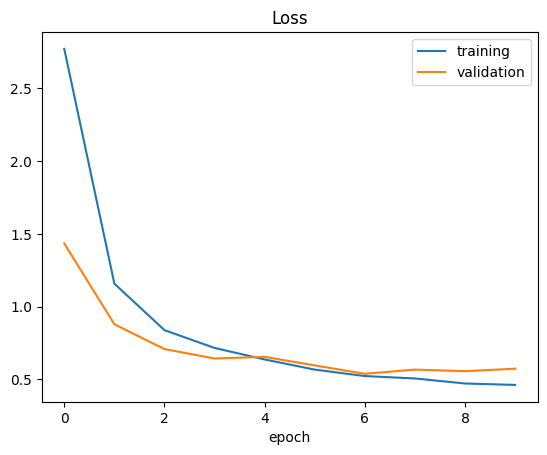

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

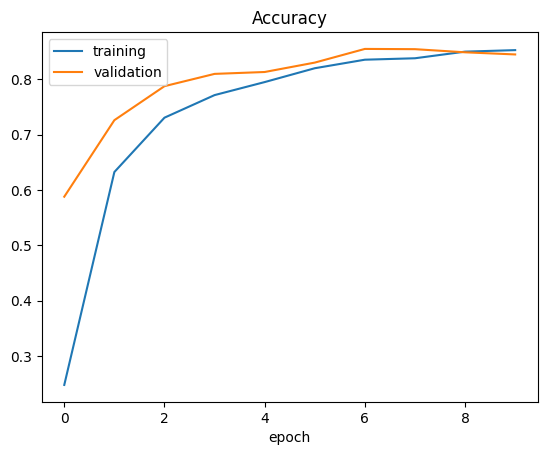

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [38]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.7354462146759033
Test Accuracy:  0.8200316429138184


Fine Tuned model

In [41]:
def modified_leNet_model():
    model = Sequential()
    #convolutional 2D consist of filters that recognize features from the image
    #30 filters - (5, 5) size of the filter - (32, 32, 1) shape of the input image
    model.add(Conv2D(60, (5, 5) ,input_shape= (32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5) , activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #we remove one drouput layer after adding data augmentation we found a larger gap between training and validation
    #model.add(Dropout(0.5))

    #reshape the output into 1D array of shape 540 = 6*6*15
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    #compile model
    model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [42]:
model = modified_leNet_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

c:\Users\bouzi\anaconda3\envs\main\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [43]:
history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 5s 51ms/step - loss: 1.8724 - accuracy: 0.4895 - val_loss: 0.5124 - val_accuracy: 0.8460
Epoch 2/10
87/87 [==============================] - 4s 50ms/step - loss: 0.3942 - accuracy: 0.8813 - val_loss: 0.2388 - val_accuracy: 0.9274
Epoch 3/10
87/87 [==============================] - 4s 47ms/step - loss: 0.1959 - accuracy: 0.9405 - val_loss: 0.1657 - val_accuracy: 0.9528
Epoch 4/10
87/87 [==============================] - 4s 47ms/step - loss: 0.1268 - accuracy: 0.9618 - val_loss: 0.1812 - val_accuracy: 0.9494
Epoch 5/10
87/87 [==============================] - 4s 47ms/step - loss: 0.0920 - accuracy: 0.9720 - val_loss: 0.1505 - val_accuracy: 0.9592
Epoch 6/10
87/87 [==============================] - 4s 48ms/step - loss: 0.0748 - accuracy: 0.9769 - val_loss: 0.1207 - val_accuracy: 0.9676
Epoch 7/10
87/87 [==============================] - 5s 52ms/step - loss: 0.0502 - accuracy: 0.9845 - val_loss: 0.1338 - val_accuracy: 0.9621
Epoch 8/10
87

Text(0.5, 0, 'epoch')

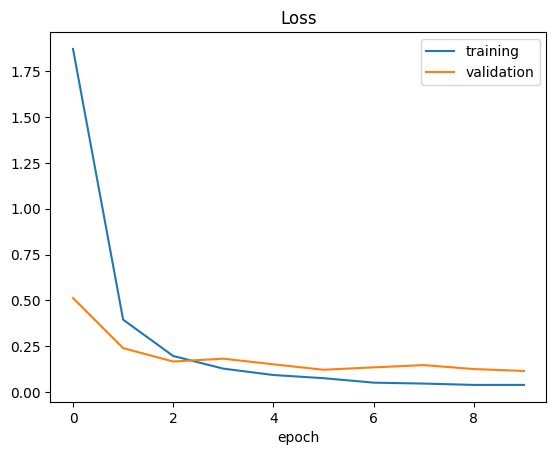

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

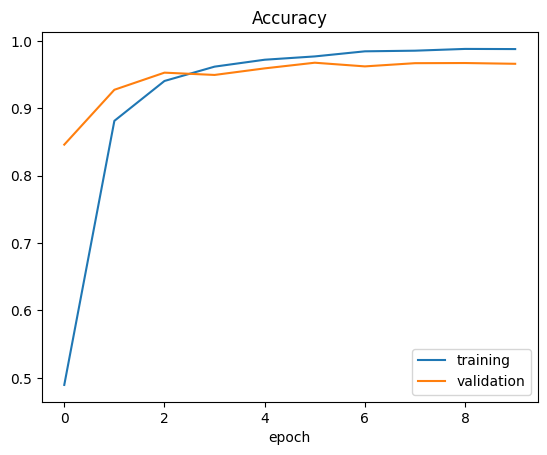

In [45]:
"""
Overfitting if the validation accuracy is below the training accuracy
"""

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [46]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.21511773765087128
Test Accuracy:  0.9477434754371643


Test

In [34]:
import requests
from PIL import Image

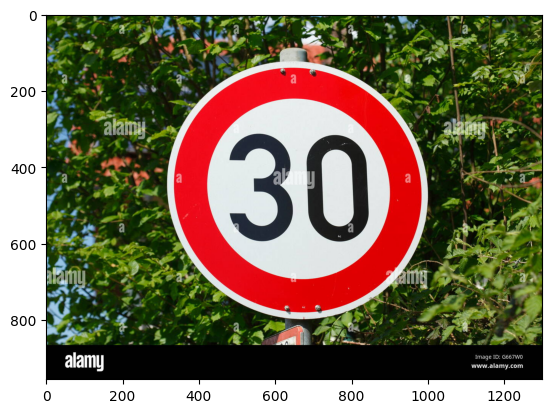

In [71]:
#fetching image for testing
#test1
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

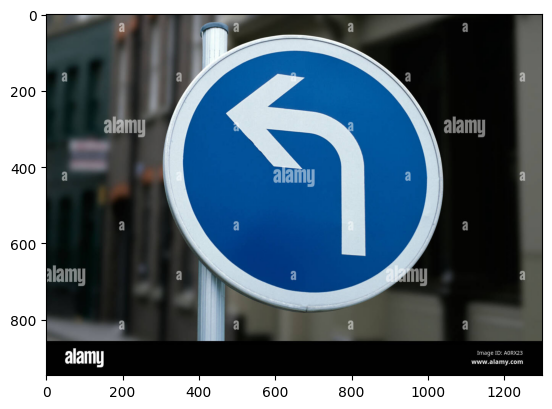

In [76]:
#test2
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw) 
plt.imshow(img, cmap=plt.get_cmap('gray'))

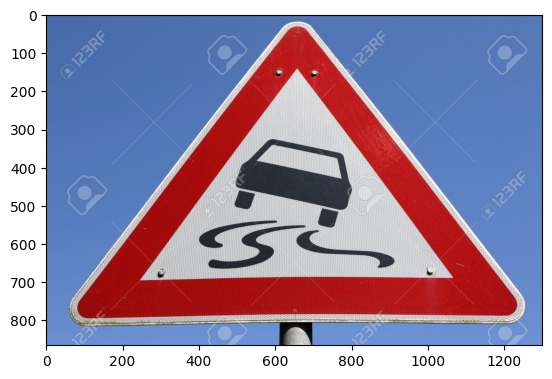

In [80]:
#test3
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw) 
plt.imshow(img, cmap=plt.get_cmap('gray'))

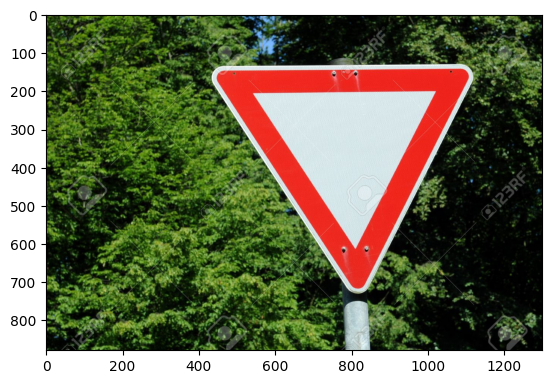

In [84]:
#test4
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw) 
plt.imshow(img, cmap=plt.get_cmap('gray'))

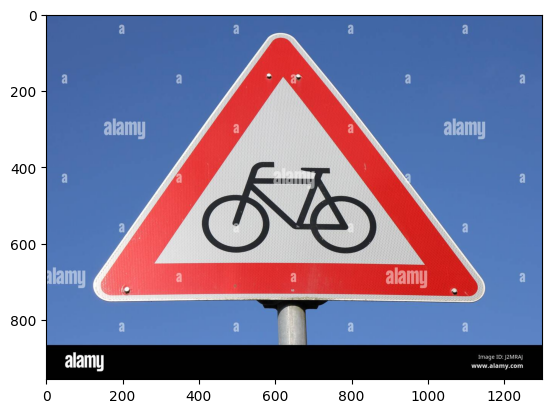

In [66]:
#test5
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw) 
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


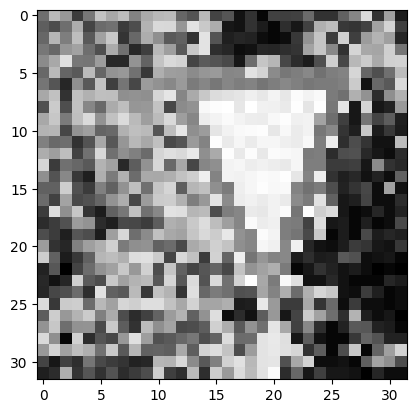

In [85]:
#preprocessing
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [86]:
#Reshape reshape
img = img.reshape(1, 32, 32, 1)

In [75]:
#Test image
print("predicted sign for test 1: "+ str(np.argmax(model.predict(img), axis=-1)))

1/1 [==============================] - 0s 23ms/step
predicted sign for test 1: [1]


In [79]:
#Test image
print("predicted sign for test 2: "+ str(np.argmax(model.predict(img), axis=-1)))

1/1 [==============================] - 0s 15ms/step
predicted sign for test 2: [11]


In [83]:
#Test image
print("predicted sign for test 3: "+ str(np.argmax(model.predict(img), axis=-1)))

1/1 [==============================] - 0s 17ms/step
predicted sign for test 3: [23]


In [87]:
#Test image
print("predicted sign for test 4: "+ str(np.argmax(model.predict(img), axis=-1)))

1/1 [==============================] - 0s 16ms/step
predicted sign for test 4: [13]


In [70]:
#Test image
print("predicted sign for test 5: "+ str(np.argmax(model.predict(img), axis=-1)))

1/1 [==============================] - 0s 18ms/step
predicted sign for test 5: [30]


Using Data Augmentation

In [47]:
from keras.preprocessing.image import ImageDataGenerator

In [48]:
datagen = ImageDataGenerator(width_shift_range = 0.1,
                    height_shift_range = 0.1,
                    zoom_range = 0.2,
                    shear_range = 0.1,
                    rotation_range = 10)

In [49]:
datagen.fit(X_train)
batches = datagen.flow(X_train, y_train, batch_size=100)

X_batch, y_batch = next(batches)

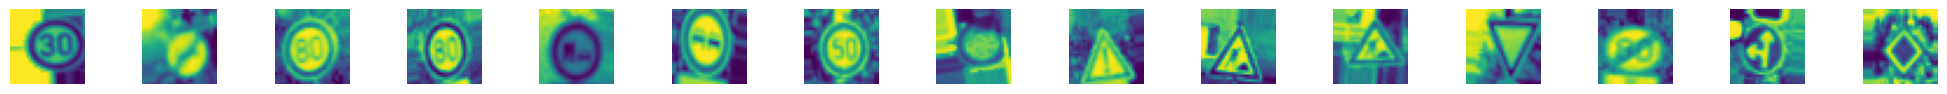

In [50]:
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

In [53]:
#fit_generator is capable of running the image generator in parrallel with the model training process
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), epochs=10, validation_data=(X_val, y_val), shuffle=1)

Epoch 1/10


C:\Users\bouzi\AppData\Local\Temp\ipykernel_12084\498051705.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), epochs=10, validation_data=(X_val, y_val), shuffle=1)


696/696 [==============================] - 7s 10ms/step - loss: 0.3273 - accuracy: 0.8987 - val_loss: 0.0890 - val_accuracy: 0.9721
Epoch 2/10
696/696 [==============================] - 7s 10ms/step - loss: 0.2313 - accuracy: 0.9282 - val_loss: 0.0545 - val_accuracy: 0.9853
Epoch 3/10
696/696 [==============================] - 7s 10ms/step - loss: 0.1858 - accuracy: 0.9421 - val_loss: 0.0450 - val_accuracy: 0.9864
Epoch 4/10
696/696 [==============================] - 7s 10ms/step - loss: 0.1584 - accuracy: 0.9520 - val_loss: 0.0374 - val_accuracy: 0.9875
Epoch 5/10
696/696 [==============================] - 7s 10ms/step - loss: 0.1373 - accuracy: 0.9588 - val_loss: 0.0836 - val_accuracy: 0.9839
Epoch 6/10
696/696 [==============================] - 7s 10ms/step - loss: 0.1296 - accuracy: 0.9610 - val_loss: 0.0415 - val_accuracy: 0.9844
Epoch 7/10
696/696 [==============================] - 7s 10ms/step - loss: 0.1158 - accuracy: 0.9637 - val_loss: 0.0512 - val_accuracy: 0.9868
Epoch 8/10

Text(0.5, 0, 'epoch')

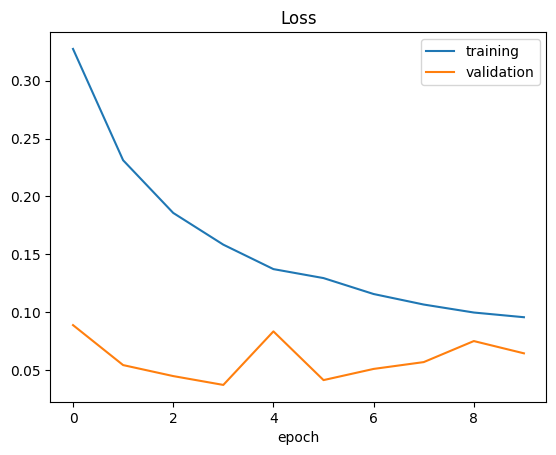

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

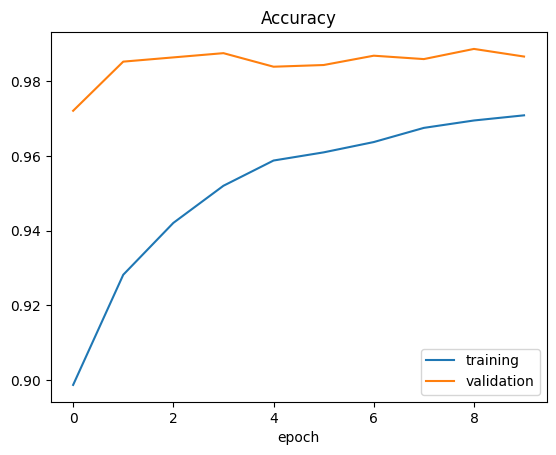

In [55]:
"""
Overfitting if the validation accuracy is below the training accuracy
"""

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')


In [56]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.09823954105377197
Test Accuracy:  0.9743468165397644
